In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x
!rm -rf ./logs/ 

In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

batch_size = 1024
num_classes = 10
epochs = 40
num_train_samples = 10000

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
def invert_image(images):
    inv_images = []
    for image in images:
        img_inv = 255 - image
        inv_images.append(img_inv.reshape(28, 28))
    return np.array(inv_images)

x_train_inv = invert_image(x_train)
x_test_inv = invert_image(x_test)
    
print(x_train_inv.shape[0], 'train samples')

def reshapeImages(images):
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

60000 train samples


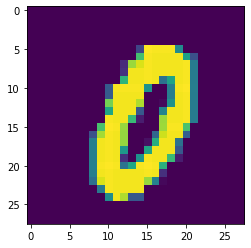

In [ ]:
plt.imshow(x_train[34].reshape(28, 28))

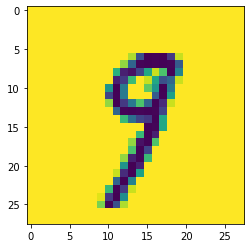

In [ ]:
plt.imshow(x_train_inv[43].reshape(28, 28))

In [ ]:
x_val = reshapeImages(x_train)[-5000:]
x_train = reshapeImages(x_train)[:num_train_samples]
x_test = reshapeImages(x_test)
x_val_inv = reshapeImages(x_train_inv)[-5000:]
x_train_inv = reshapeImages(x_train_inv)[:num_train_samples]
x_test_inv = reshapeImages(x_test_inv)

# convert class vectors to binary class matrices
y_val = keras.utils.to_categorical(y_train, num_classes)[-5000:]
y_train = keras.utils.to_categorical(y_train, num_classes)[:num_train_samples]
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 samples
60000 samples
10000 samples
60000 samples
60000 samples
10000 samples


In [ ]:
## first model (training of whole model)
input1 = keras.layers.Input(shape=(784, ))
dense1 = keras.layers.Dense(128, activation='relu')(input1)
dense2 = keras.layers.Dense(128, activation='relu')(dense1)
dense3 = keras.layers.Dense(20, activation='relu')(dense2)
output = keras.layers.Dense(num_classes, activation='softmax')(dense3)

model = keras.Model(inputs=input1, outputs=[dense3,output])

model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 119,782
Trainable params: 119,782
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 128
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=200000).batch(batch_size)

train_dataset_inv = tf.data.Dataset.from_tensor_slices((x_train_inv, y_train))
train_dataset_inv = train_dataset_inv.shuffle(buffer_size=200000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate((x_val,x_val_inv)), np.concatenate((y_val,y_val))))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
def distance_loss(predictions, predictions_inv, ys, ys_inv):
    def calculate_distance(tensor):
      equal =  tf.math.equal(tensor[1], ys_inv)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_inv, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    d = tf.map_fn(calculate_distance, (predictions,ys), dtype=tf.float32)
    return tf.math.reduce_mean(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_inv, x_batch_train, y_batch_train, y_train):

    with tf.GradientTape(persistent='TRUE') as tape:   
      hidden_logits = model(x_batch_train, training='TRUE')[0]
      hidden_logits_inv = model(x_train_inv, training='TRUE')[0]
      loss_ec = distance_loss(hidden_logits, hidden_logits_inv, y_batch_train, y_train)
      logits = model(x_batch, training='TRUE')[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.1*loss_ec

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_ec, loss_cross

In [ ]:
euclid_losses = []
cross_entropy_losses = []
train_accuracy = []
epochs = 15

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch_train, y_batch_train),(x_batch_train_inv, y_batch_train_inv) in zip(train_dataset, train_dataset_inv):
        x_batch = K.concatenate([x_batch_train,x_batch_train_inv], axis=0)
        y_batch = K.concatenate([y_batch_train,y_batch_train_inv], axis=0)   
        loss_value, e_loss, loss_cross = train_step(model, optimizer, x_batch, y_batch, tf.constant(x_train_inv, dtype=tf.float32), x_batch_train, y_batch_train, y_train)
        ##loss_value, e_loss, loss_cross = train_step(model, optimizer, x_batch, y_batch, x_batch_train_inv, x_batch_train, y_batch_train, y_batch_train_rot)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Log every 50 batches.
    if step % 50 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Euclid loss and cross entropy loss at step %s: %s  %s' % (step, float(e_loss),float(loss_cross)))

    step +=1
    euclid_losses.append(float(e_loss))
    cross_entropy_losses.append(float(loss_cross))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Instructions for updating:
Use tf.identity instead.
Training acc over epoch: 0.11214999854564667
Training loss (for one batch) at step 0: 2.302267074584961
Euclid loss and cross entropy loss at step 0: 0.0  2.302267074584961
Validation acc: 0.10599999874830246
Start of epoch 1
Training acc over epoch: 0.11270000040531158
Training loss (for one batch) at step 0: 2.3034870624542236
Euclid loss and cross entropy loss at step 0: 0.0  2.3034870624542236
Validation acc: 0.10599999874830246
Start of epoch 2
Training acc over epoch: 0.11270000040531158
Training loss (for one batch) at step 0: 2.3021204471588135
Euclid loss and cross entropy loss at step 0: 0.0  2.3021204471588135
Validation acc: 0.10599999874830246
Start of epoch 3
Training acc over epoch: 0.11270000040531158
Training loss (for one batch) at step 0: 2.301069498062134
Euclid loss and cross entropy loss at step 0: 0.0  2.301069498062134
Validation acc: 0.10599999874830246
Start of epoch 4
Training acc over epoch

In [ ]:
plt.plot(euclid_losses)
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['euclid_loss', 'cross_entropy_loss'], loc='best')
plt.show()

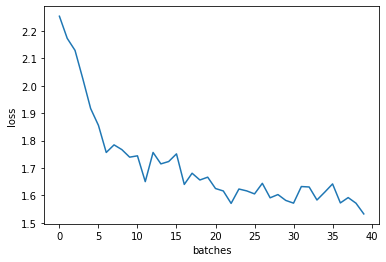

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

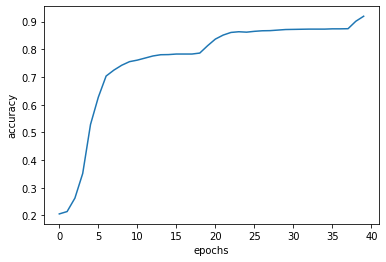

In [ ]:
plt.plot(train_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
# retrain last layer of fair model to predict the digits and the origin of the data set 
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 
model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
outputSet = keras.layers.Dense(2, activation="softmax", name="outputSet")(last)
outputNrs = keras.layers.Dense(num_classes, activation="softmax", name="outputNrs")(last)
model_new = keras.models.Model(model_new.input, [outputNrs, outputSet])

for layer in model_new.layers:
    print(layer, layer.trainable)
    
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics={"outputSet":'accuracy', "outputNrs":'accuracy'})

model_new.summary()

y_train_not_inv = np.ones(num_train_samples)
y_train_inv = np.zeros(num_train_samples)

y_test_not_inv = np.ones(10000)
y_test_inv = np.zeros(10000)

y_train_set = keras.utils.to_categorical(np.concatenate((y_train_not_inv,y_train_inv)), 2)
y_test_set = keras.utils.to_categorical(np.concatenate((y_test_not_inv,y_test_inv)), 2)

history = model_new.fit(np.concatenate((x_train, x_train_inv)), [np.concatenate((y_train, y_train)),y_train_set],
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(np.concatenate((x_test, x_test_inv)), [np.concatenate((y_test, y_test)),y_test_set]))
score = model_new.evaluate(np.concatenate((x_test, x_test_inv)), [np.concatenate((y_test, y_test)),y_test_set], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# preparation for TSNE plot
layer_of_interest=3
intermediate_layer_model = keras.models.Model(inputs=model_new.input,
                                 outputs=model_new.get_layer("dense_2").output)
intermediates = intermediate_layer_model.predict(np.concatenate((x_test, x_test_inv)))
colors = ["blue", "green", "red", "yellow", "orange", "grey", "black", "pink", "purple", "brown"]
color_intermediates = np.array(colors)[np.argmax(np.concatenate((y_test,y_test)), axis=1)]

tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)

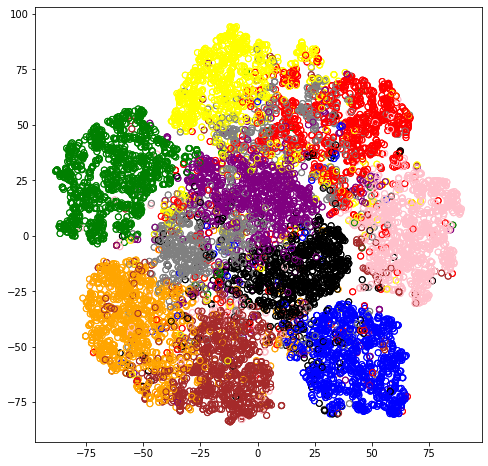

In [ ]:
# TSNE for digits
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], facecolors='none', edgecolors=color_intermediates)
plt.show()

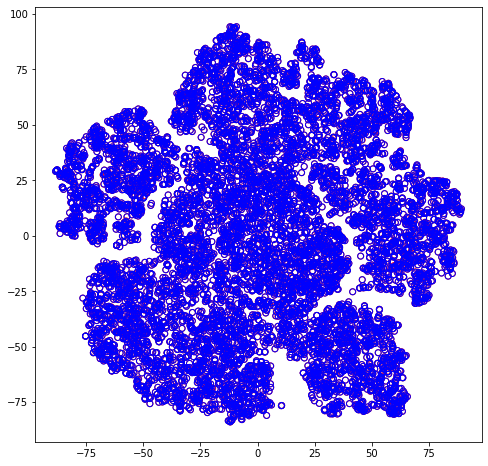

In [ ]:
# TSNE for data set origin (inverted/ not inverted)
colors = ["blue", "red"]
labels = np.concatenate((y_test_not_inv,y_test_inv)).astype(int)
color_intermediates = np.array(colors)[labels]
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], facecolors='none', edgecolors=color_intermediates)
plt.show()

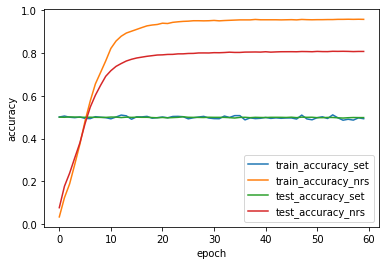

In [ ]:
plt.plot(history.history['outputSet_accuracy'])
plt.plot(history.history['outputNrs_accuracy'])
plt.plot(history.history['val_outputSet_accuracy'])
plt.plot(history.history['val_outputNrs_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy_set', 'train_accuracy_nrs','test_accuracy_set','test_accuracy_nrs'], loc='best')
plt.show()

In [ ]:
# retrain model on last layer to predict digits in preparation to calculate 
# confusion matrix and fairness measures
model_ = keras.models.clone_model(model)
model_.set_weights(model.get_weights()) 

model_._layers.pop()
for layer in model_.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_.layers[-1].output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(last)
model_ = keras.models.Model(model_.input, output)

for layer in model_.layers:
    print(layer, layer.trainable)
    
model_.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_.summary()

history = model_.fit(np.concatenate((x_train, x_train_inv)), np.concatenate((y_train, y_train)),epochs=20,
    shuffle=True,
    verbose=1)

y_pred = model_.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred_inv = model_.predict(x_test_inv)
y_pred_inv = np.argmax(y_pred_inv, axis=1)

y_test_binary = np.argmax(y_test, axis=1)
y_test_inv_binary = np.argmax(y_test, axis=1)

cnf_matrix = confusion_matrix(y_test_binary, y_pred)
cnf_matrix_inv = confusion_matrix(y_test_inv_binary, y_pred_inv)

fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
tp = np.diag(cnf_matrix)
tn = cnf_matrix.sum() - (fp + fn + tp)

fp_inv = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix_rot)  
fn_ = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix_rot)
tp_rot = np.diag(cnf_matrix_inv)
tn_inv = cnf_matrix_inv.sum() - (fp_inv + fn_inv + tp_inv)

## female
prob_true_beutel = (tp + fp)/y_test.shape[0]
print("prob_1 (beutel):", prob_true_beutel)
acc = (tp + tn)/y_test.shape[0]
print("acc:", acc)
tpr = tp/(tp + fn)
print("tpr:",tpr)
ppv = tp/(tp + fp)
print("ppv:",ppv)
tnr = tn/(tn + fp)
print("tnr:",tnr)

print("---------------------------------------------------")
## male
prob_true_beutel_inv = (tp_inv + fp_inv)/y_test.shape[0]
print("prob_1 inv (beutel):", prob_true_beutel_inv)
acc_inv = (tp_inv + tn_inv)/y_test.shape[0]
print("acc inv:", acc_inv)
tpr_inv = tp_inv/(tp_inv + fn_inv)
print("tpr inv:", tpr_inv)
ppv_inv = tp_inv/(tp_inv + fp_inv)
print("ppv inv:",ppv_inv)
tnr_inv = tn_inv/(tn_inv + fp_inv)
print("tnr inv:",tnr_inv)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel - prob_true_beutel_inv)
pred_parity = abs(ppv_inv - ppv_inv)
equal_opportunity = abs(tpr - tpr_inv) ## = equality_gap_1
equality_gap_0_beutel = abs(tnr - tnr_inv)
accuracy_gap = abs(acc - acc_inv)

print("parity gap (beutel):", parity_gap_beutel)
print("predictive parity:", pred_parity)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)
print("equality gap 0 (beutel):", equality_gap_0_beutel)
print("accuracy gap:", accuracy_gap)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7f11b4e208> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f7f11b4e390> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f7f11b4e5c0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f7f11b4e978> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f7f11b61630> True
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
___

In [ ]:
# prepare data set to retrain last layer of model on specific number in addition
# with sensitive attribute
numberToLookAt = 9
keepIndeces_train = np.where((np.argmax(y_train, axis = 1) == numberToLookAt))[0]
y_train_new = np.zeros([y_train.shape[0], 2])
for i in range(1, y_train.shape[0]):
  if i in keepIndeces_train:
    y_train_new[i] = [1, 0]

keepIndeces_test = np.where((np.argmax(y_test, axis = 1) == numberToLookAt))[0]
y_test_new = np.zeros([y_test.shape[0], 2])
for i in range(1, y_test.shape[0]):
  if i in keepIndeces_test:
    y_test_new[i] = [1, 0]

In [ ]:
rep_layer = model(x_train)[0]
rep_layer_inv = model(x_train_inv)[0]

rep_train_x = np.concatenate((rep_layer, rep_layer_inv))
train_y = np.concatenate((y_train_new, y_train_new))

train_sens = np.zeros((rep_layer.shape[0],1))
inv_train_sens = np.ones((rep_layer_inv.shape[0],1))

train_sens_ = np.concatenate((train_sens, inv_train_sens))

rep_layer_test = model(x_test)[0]
rep_layer_inv_test = model(x_test_inv)[0]

rep_test_x = np.concatenate((rep_layer_inv_test, rep_layer_test))
test_y = np.concatenate((y_test_new, y_test_new))

test_sens = np.zeros((rep_layer_inv_test.shape[0],1))
inv_test_sens = np.ones((rep_layer_test.shape[0],1))

test_sens_ = np.concatenate((test_sens, inv_test_sens))
test_sens_ = np.random.randint(2, size=2*model(x_test)[0].shape[0])

rep_train_x, train_sens_, train_y = shuffle(rep_train_x, train_sens_ , train_y)
rep_test_x, test_sens_, test_y = shuffle(rep_test_x, test_sens_ , test_y)

In [ ]:
# retrain last layer of model on specific number with additional input of the
# sensitive attribute
input2 = keras.layers.Input(shape=20)
dense2_1 = keras.layers.Dense(1)(input2)
input_sens = keras.layers.Input(shape=1, name='input_sens')
mergedLayer = keras.layers.concatenate([dense2_1, input_sens], axis = 1)
output2 = keras.layers.Dense(2, activation='softmax')(mergedLayer)
model5 = keras.Model(inputs=[input2, input_sens], outputs=[output2])

model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model5.summary()

history = model5.fit([rep_train_x, train_sens_], train_y,
                     batch_size=128,
                     epochs=25,
                     verbose=1,
                     shuffle = True)
score = model5.evaluate([rep_test_x, test_sens_], test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 1)            21          input_7[0][0]                    
__________________________________________________________________________________________________
input_sens (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 2)            0           dense_14[0][0]                   
                                                                 input_sens[0][0]           

In [ ]:
# plot outputs of the fair representation in a histogram
intermediate_layer_model = keras.models.Model(inputs = model5.input, outputs = model5.get_layer("dense_4").output)
intermediate_output = intermediate_layer_model.predict([rep_layer_test, test_sens])
intermediate_output_inv = intermediate_layer_model.predict([rep_layer_inv_test, inv_test_sens])

plt.hist(intermediate_output, density = True, alpha=0.5, label='not inverted', bins= 20)
plt.hist(intermediate_output_inv, density = True, alpha=0.5, label='inverted', bins = 20)
plt.xlabel("output representation layer")
plt.legend(loc='best')
plt.savefig("hist_rep1.png")

In [ ]:
for layer in model5.layers: print(layer.name, layer.get_weights())

input_7 []
dense_14 [array([[ 0.609652  ],
       [-0.261822  ],
       [ 0.27859998],
       [ 0.40890604],
       [-0.35151744],
       [ 0.23074675],
       [-0.00259442],
       [ 0.26690197],
       [-0.13861862],
       [ 0.37801647],
       [ 0.43087482],
       [ 0.1957291 ],
       [ 0.351473  ],
       [ 0.58007854],
       [-0.08220374],
       [-0.17638817],
       [ 0.00653881],
       [-0.01660164],
       [-0.7315146 ],
       [-0.22265409]], dtype=float32), array([-0.01197281], dtype=float32)]
input_sens []
concatenate_5 []
dense_15 [array([[-0.10432821, -0.21215312],
       [ 0.6163643 ,  0.6806594 ]], dtype=float32), array([ 0.04502969, -0.0450297 ], dtype=float32)]


In [ ]:
# calcuate confusion matrix and fairness measures if sensitive attribute is added
# back as input to fair model
y_pred = model2.predict([rep_layer_test, test_sens])
y_pred = np.argmax(y_pred, axis=1)

y_pred_inv = model2.predict([rep_layer_inv_test, inv_test_sens])
y_pred_inv = np.argmax(y_pred_inv, axis=1)

y_test_binary = np.argmax(y_test_new, axis=1)
y_test_inv_binary = np.argmax(y_test_new, axis=1)

cnf_matrix = confusion_matrix(y_test_binary, y_pred)
cnf_matrix_inv = confusion_matrix(y_test_inv_binary, y_pred_inv)

fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
tp = np.diag(cnf_matrix)
tn = cnf_matrix.sum() - (fp + fn + tp)

fp_inv = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix_inv)  
fn_inv = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix_inv)
tp_inv = np.diag(cnf_matrix_inv)
tn_inv = cnf_matrix_inv.sum() - (fp_inv + fn_inv + tp_inv)

## female
prob_true_beutel = (tp + fp)/y_test.shape[0]
print("prob_1 (beutel):", prob_true_beutel)
acc = (tp + tn)/y_test.shape[0]
print("acc:", acc)
tpr = tp/(tp + fn)
print("tpr:",tpr)
ppv = tp/(tp + fp)
print("ppv:",ppv)
tnr = tn/(tn + fp)
print("tnr:",tnr)

print("---------------------------------------------------")
## male
prob_true_beutel_inv = (tp_inv + fp_inv)/y_test.shape[0]
print("prob_1 inv (beutel):", prob_true_beutel_inv)
acc_inv = (tp_inv + tn_inv)/y_test.shape[0]
print("acc inv:", acc_inv)
tpr_inv = tp_inv/(tp_inv + fn_inv)
print("tpr inv:", tpr_inv)
ppv_inv = tp_inv/(tp_inv + fp_inv)
print("ppv inv:",ppv_inv)
tnr_inv = tn_inv/(tn_inv + fp_inv)
print("tnr inv:",tnr_inv)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel - prob_true_beutel_inv)
pred_parity = abs(ppv_inv - ppv_inv)
equal_opportunity = abs(tpr - tpr_inv) ## = equality_gap_1
equality_gap_0_beutel = abs(tnr - tnr_inv)
accuracy_gap = abs(acc - acc_inv)

print("parity gap (beutel):", parity_gap_beutel)
print("predictive parity:", pred_parity)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)
print("equality gap 0 (beutel):", equality_gap_0_beutel)
print("accuracy gap:", accuracy_gap)